In [1]:
import pandas as pd
import numpy as np
# import plotly.express as px
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('../data/data.csv').sample(frac=0.01, random_state=37)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
2742285,2021-09-30 21:13:43.000000,14,145,26046526705677232,0,2,7,145,0.003,0.119393,-2.813851,389,0.003,0.106859,-3.067688,1,0
5938069,2021-10-01 20:22:30.000000,45,84,2337401976056301079,0,3,7,84,0.001,0.194752,-3.223216,78,0.001,0.205095,-3.357224,1,0
4984640,2021-09-27 18:06:13.000000,276,660,7260007107358513570,0,0,9,660,0.050,0.095239,-3.983387,768,0.050,0.082167,-4.072194,1,0
11446352,2021-09-29 16:29:31.000000,1,981,5163493493748815305,0,1,3,981,0.021,0.278653,-3.629209,946,0.004,0.114355,-3.120265,1,0
4790655,2021-09-28 18:23:48.000000,8,361,5143959845351659368,0,4,0,361,0.008,0.017722,-2.391956,12423579,100.000,0.007353,-2.095399,1,0


## Анализ

In [4]:
data.drop(['campaign_clicks', 'impressions'], axis=1, inplace=True)
data.head()

KeyError: "['campaign_clicks', 'impressions'] not found in axis"

In [5]:
data.shape

(158215, 15)

In [6]:
data.nunique()

date_time     136137
zone_id         1075
banner_id       1148
oaid_hash     148462
os_id              9
country_id        17
banner_id0     10666
rate0            212
g0            154976
coeff_sum0    135258
banner_id1     32723
rate1            422
g1            154424
coeff_sum1    136571
clicks             2
dtype: int64

array([[<AxesSubplot: title={'center': 'g0'}>,
        <AxesSubplot: title={'center': 'g1'}>],
       [<AxesSubplot: title={'center': 'coeff_sum0'}>,
        <AxesSubplot: title={'center': 'coeff_sum1'}>],
       [<AxesSubplot: title={'center': 'rate0'}>,
        <AxesSubplot: title={'center': 'rate1'}>]], dtype=object)

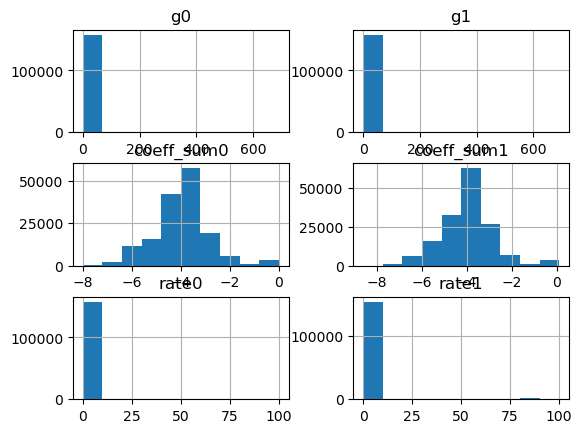

In [7]:
data[['g0', 'g1', 'coeff_sum0', 'coeff_sum1', 'rate0', 'rate1']].hist()

In [8]:
def show_info(col: str):
    print(f'info of {col}')
    print(f' MIN: {data[col].min()}')
    print(f' MAX: {data[col].max()}')
    print(f' MEAN: {data[col].mean()}')
    print(f' MEDIAN: {data[col].median()}')

In [9]:
new_f = ['g0', 'g1', 'coeff_sum0', 'coeff_sum1', 'rate0', 'rate1']
for f in new_f:
    show_info(f)

info of g0
 MIN: 0.0
 MAX: 691.088272234726
 MEAN: 0.7950423329676161
 MEDIAN: 0.0352205198908191
info of g1
 MIN: 0.0
 MAX: 691.08827222489
 MEAN: 0.5630889815694168
 MEDIAN: 0.0354339218903576
info of coeff_sum0
 MIN: -8.01286186185302
 MAX: 0.0
 MEAN: -3.97748112333946
 MEDIAN: -3.92105090985278
info of coeff_sum1
 MIN: -8.60041623487431
 MAX: 0.112311235456297
 MEAN: -3.9676780448848623
 MEDIAN: -3.93090483651505
info of rate0
 MIN: 0.0001
 MAX: 100.0
 MEAN: 0.19629075443856744
 MEDIAN: 0.01
info of rate1
 MIN: 0.00097
 MAX: 100.0
 MEAN: 1.445497033702961
 MEDIAN: 0.014


In [10]:
data = data.dropna()
data = data[data['banner_id'] == data['banner_id0']]

In [11]:
data.shape

(139212, 15)

In [12]:
data.nunique()

date_time     122032
zone_id         1035
banner_id       1134
oaid_hash     131123
os_id              9
country_id        17
banner_id0      1134
rate0             48
g0            139169
coeff_sum0    121704
banner_id1     32337
rate1            391
g1            135641
coeff_sum1    122496
clicks             2
dtype: int64

In [13]:
# data = data.drop(['banner_id'], axis=1)

In [14]:
data['date'] = data['date_time'].apply(lambda s: s.split()[0])

In [15]:
data['time'] = data['date_time'].apply(lambda s: s.split()[1])

In [16]:
data.drop('date_time', axis=1, inplace=True)
data.head(2)

,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,clicks,date,time
2742285,14,145,26046526705677232,2,7,145,0.003,0.119393,-2.813851,389,0.003,0.106859,-3.067688,0,2021-09-30,21:13:43.000000
5938069,45,84,2337401976056301079,3,7,84,0.001,0.194752,-3.223216,78,0.001,0.205095,-3.357224,0,2021-10-01,20:22:30.000000


In [17]:
data.date.unique()

array(['2021-09-30', '2021-10-01', '2021-09-27', '2021-09-29',
       '2021-09-28', '2021-10-02', '2021-09-26'], dtype=object)

In [18]:
data[ data.date == '2021-09-01' ]

,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,clicks,date,time


## feature_engineering

In [20]:
data['hour'] = data['time'].apply(lambda s: int(float(s.split(':')[0])))
data['minute'] = data['time'].apply(lambda s: int(float(s.split(':')[1])))

In [21]:
indx_test = data.date == '2021-10-02'
indx_test.sum()

18969

In [22]:
data.drop(['date', 'time'], axis=1, inplace=True)
data.head()

,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,clicks,hour,minute
2742285,14,145,26046526705677232,2,7,145,0.003,0.119393,-2.813851,389,0.003,0.106859,-3.067688,0,21,13
5938069,45,84,2337401976056301079,3,7,84,0.001,0.194752,-3.223216,78,0.001,0.205095,-3.357224,0,20,22
4984640,276,660,7260007107358513570,0,9,660,0.050,0.095239,-3.983387,768,0.050,0.082167,-4.072194,0,18,6
11446352,1,981,5163493493748815305,1,3,981,0.021,0.278653,-3.629209,946,0.004,0.114355,-3.120265,0,16,29
4790655,8,361,5143959845351659368,4,0,361,0.008,0.017722,-2.391956,12423579,100.000,0.007353,-2.095399,0,18,23


In [23]:
data['hour_sin'] = np.sin(data.hour*(2.*np.pi/24))
data['hour_cos'] = np.cos(data.hour*(2.*np.pi/24))

data['minute_sin'] = np.sin((data.minute-1)*(2.*np.pi/60))
data['minute_cos'] = np.cos((data.minute-1)*(2.*np.pi/60))

In [24]:
data.drop('hour', axis=1, inplace=True)
data.drop('minute', axis=1, inplace=True)
data.head()

,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,clicks,hour_sin,hour_cos,minute_sin,minute_cos
2742285,14,145,26046526705677232,2,7,145,0.003,0.119393,-2.813851,389,0.003,0.106859,-3.067688,0,-0.707107,7.071068e-01,0.951057,0.309017
5938069,45,84,2337401976056301079,3,7,84,0.001,0.194752,-3.223216,78,0.001,0.205095,-3.357224,0,-0.866025,5.000000e-01,0.809017,-0.587785
4984640,276,660,7260007107358513570,0,9,660,0.050,0.095239,-3.983387,768,0.050,0.082167,-4.072194,0,-1.000000,-1.836970e-16,0.500000,0.866025
11446352,1,981,5163493493748815305,1,3,981,0.021,0.278653,-3.629209,946,0.004,0.114355,-3.120265,0,-0.866025,-5.000000e-01,0.207912,-0.978148
4790655,8,361,5143959845351659368,4,0,361,0.008,0.017722,-2.391956,12423579,100.000,0.007353,-2.095399,0,-1.000000,-1.836970e-16,0.743145,-0.669131


In [25]:
data.nunique()

zone_id         1035
banner_id       1134
oaid_hash     131123
os_id              9
country_id        17
banner_id0      1134
rate0             48
g0            139169
coeff_sum0    121704
banner_id1     32337
rate1            391
g1            135641
coeff_sum1    122496
clicks             2
hour_sin          24
hour_cos          24
minute_sin        60
minute_cos        58
dtype: int64

In [26]:
categories = ['os_id', 'country_id']
f_to_drop = ['oaid_hash', 'zone_id']

In [27]:
data.drop(f_to_drop, axis=1, inplace=True)

In [28]:
data_categories = data[categories]

In [30]:
encoder = OneHotEncoder(sparse=False)

In [31]:
encoder.fit(data_categories)

OneHotEncoder(sparse=False)

In [32]:
data_categories_encodeed = encoder.transform(data_categories)

In [33]:
data_categories_encodeed.shape

(139212, 26)

In [34]:
data.drop(data_categories, axis=1, inplace=True)
data.head()

,banner_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,clicks,hour_sin,hour_cos,minute_sin,minute_cos
2742285,145,145,0.003,0.119393,-2.813851,389,0.003,0.106859,-3.067688,0,-0.707107,7.071068e-01,0.951057,0.309017
5938069,84,84,0.001,0.194752,-3.223216,78,0.001,0.205095,-3.357224,0,-0.866025,5.000000e-01,0.809017,-0.587785
4984640,660,660,0.050,0.095239,-3.983387,768,0.050,0.082167,-4.072194,0,-1.000000,-1.836970e-16,0.500000,0.866025
11446352,981,981,0.021,0.278653,-3.629209,946,0.004,0.114355,-3.120265,0,-0.866025,-5.000000e-01,0.207912,-0.978148
4790655,361,361,0.008,0.017722,-2.391956,12423579,100.000,0.007353,-2.095399,0,-1.000000,-1.836970e-16,0.743145,-0.669131


In [35]:
data.shape

(139212, 14)

In [40]:
name_enc_f = list(range(26))

In [49]:
df_data_categories_encodeed = pd.DataFrame(data_categories_encodeed, columns = name_enc_f, index = data.index)
df_data_categories_encodeed.head(2)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
2742285,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5938069,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
dataset = pd.concat([df_data_categories_encodeed, data.drop(['clicks'], axis=1)],ignore_index=False, axis=1, join="inner")
dataset.head(2)

,0,1,2,3,4,5,6,7,8,9,...,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,hour_sin,hour_cos,minute_sin,minute_cos
2742285,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119393,-2.813851,389,0.003,0.106859,-3.067688,-0.707107,0.707107,0.951057,0.309017
5938069,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.194752,-3.223216,78,0.001,0.205095,-3.357224,-0.866025,0.500000,0.809017,-0.587785


In [59]:
dataset.shape

(139212, 39)

In [60]:
indx_train = ~indx_test

dataset_train = dataset[indx_train]
dataset_test = dataset[indx_test]

In [61]:
y_train = data[indx_train].clicks
y_test = data[indx_test].clicks

In [62]:
dataset_train.shape

(120243, 39)

In [63]:
X_train, y_train = shuffle(dataset_train, y_train)

In [64]:
X_test_banner0 = dataset_test.copy()
X_test_banner1 = dataset_test.copy()
X_test_banner1['banner_id'] = X_test_banner1['banner_id1']

In [66]:
X_test_banner1.nunique()

0                 2
1                 2
2                 2
3                 2
4                 2
5                 2
6                 2
7                 1
8                 2
9                 2
10                2
11                2
12                2
13                2
14                2
15                2
16                2
17                2
18                2
19                2
20                2
21                2
22                2
23                2
24                2
25                2
banner_id      5131
banner_id0      559
rate0            37
g0            18964
coeff_sum0    16415
banner_id1     5131
rate1           159
g1            18636
coeff_sum1    16413
hour_sin         24
hour_cos         24
minute_sin       60
minute_cos       58
dtype: int64

In [67]:
col_to_drop = ['banner_id0', 'banner_id1']
X_train.drop(col_to_drop, axis=1, inplace=True)
X_test_banner0.drop(col_to_drop, axis=1, inplace=True)
X_test_banner1.drop(col_to_drop, axis=1, inplace=True)

## Train
Основаная модель - Логистическая регрессия.
В качестве оптимайзера взял с лекции ```liblinear```.

In [68]:
model = LogisticRegression(C=0.07)
model.fit(X_train, y_train)

/Users/thebest/miniconda3/envs/hse-made-big-data/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/thebest/miniconda3/envs/hse-made-big-data/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.07)

In [71]:
y_pred = model.predict_proba(X_test_banner0)[:, 1]
my_log_loss = log_loss(y_test, y_pred)
my_auc = roc_auc_score(y_test, y_pred)
print(f'======= Test Metrics =======')
print(f'======= My Model =======')
print(f'log_loss: {my_log_loss}')
print(f'auc: {my_auc}')

======= Test Metrics =======
======= My Model =======
log_loss: 0.1361113341711755
auc: 0.7789113388572535


/Users/thebest/miniconda3/envs/hse-made-big-data/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Это была метрика нашей моделей

In [107]:
y_pred = model.predict_proba(dataset_test)[:, 1]
my_log_loss = log_loss(y_test, y_pred)
my_auc = roc_auc_score(y_test, y_pred)
print(f'======= Test Metrics =======')
print(f'======= My Model =======')
print(f'log_loss: {my_log_loss}')
print(f'auc: {my_auc}')

======= Test Metrics =======
======= My Model =======
log_loss: 0.1334549924173812
auc: 0.7801157566633397


Это была метрика прошлой моделей из hw01

In [72]:
X_test_banner0.head(2)

,0,1,2,3,4,5,6,7,8,9,...,rate0,g0,coeff_sum0,rate1,g1,coeff_sum1,hour_sin,hour_cos,minute_sin,minute_cos
6735270,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.006,0.037927,-3.565956,0.006,0.032634,-3.742006,-0.258819,-0.965926,0.104528,0.994522
893050,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.006,0.036902,-1.062262,0.010,0.162925,-2.342286,0.965926,0.258819,-0.994522,0.104528


In [73]:
test_ips = X_test_banner0[['g0', 'coeff_sum0', 'g1', 'coeff_sum1']]

In [74]:
test_ips['coeff_sum0_current'] = scipy.special.logit(model.predict_proba(X_test_banner0)[:, 1])
test_ips['coeff_sum1_current'] = scipy.special.logit(model.predict_proba(X_test_banner1)[:, 1])

/Users/thebest/miniconda3/envs/hse-made-big-data/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/var/folders/j0/1l0qrqy50rb8ph6trtn7qkyr0000gn/T/ipykernel_14313/335306189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ips['coeff_sum0_current'] = scipy.special.logit(model.predict_proba(X_test_banner0)[:, 1])
/Users/thebest/miniconda3/envs/hse-made-big-data/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1

In [77]:
test_ips['pi0'] = 1 - scipy.stats.norm.cdf((test_ips['coeff_sum1'] - test_ips['coeff_sum0']) / np.sqrt(test_ips['g0'] ** 2 + test_ips['g1'] ** 2))
test_ips['pi1'] = 1 - scipy.stats.norm.cdf((test_ips['coeff_sum1_current'] - test_ips['coeff_sum0_current']) / np.sqrt(test_ips['g0'] ** 2 + test_ips['g1'] ** 2))

/var/folders/j0/1l0qrqy50rb8ph6trtn7qkyr0000gn/T/ipykernel_14313/3471643419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ips['pi0'] = 1 - scipy.stats.norm.cdf((test_ips['coeff_sum1'] - test_ips['coeff_sum0']) / np.sqrt(test_ips['g0'] ** 2 + test_ips['g1'] ** 2))
/var/folders/j0/1l0qrqy50rb8ph6trtn7qkyr0000gn/T/ipykernel_14313/3471643419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ips['pi1'] = 1 - scipy.stats.norm.cdf((test_ips['coeff_sum1_current'] - test_ips['coeff_sum0_current']) 

In [84]:
cips = np.mean(y_test * np.minimum(test_ips['pi1'] / test_ips['pi0'], 10))
cips

0.08089754643417983